In [1]:
from taxi_pakage import *
%matplotlib inline

In [2]:
taxi = pd.read_csv("edited_taxi.csv")
taxi['log_duration'] = taxi['trip_duration'].apply(lambda x: np.log1p(x))
taxi['log_dist'] = taxi['dist'].apply(lambda x: np.log1p(x))
taxi['sqrt_log_dist'] = taxi['dist'].apply(lambda x: np.sqrt(np.log1p(x)))
taxi['cbrt_log_dist'] = taxi['dist'].apply(lambda x: np.cbrt(np.log1p(x)))

taxi['velo'] = taxi['dist']/taxi['trip_duration']*3600 # 시속
taxi['no_passenger'] = taxi['passenger_count'].apply(lambda x: 1 if x == 0 else 0)
taxi['log_dist2'] = taxi['log_dist'].apply(lambda x: x**2)

In [3]:
taxi = taxi[taxi['trip_duration'] < 1500000].reset_index(drop=True)
taxi = taxi[taxi['velo']<80]

taxi.tail()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist,year,...,holiday,weekday,trip_duration,log_duration,log_dist,sqrt_log_dist,cbrt_log_dist,velo,no_passenger,log_dist2
1458635,2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,0,1.224311,2016,...,0,5,778,6.658011,0.799447,0.894118,0.928104,5.665192,0,0.639116
1458636,1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,0,6.046037,2016,...,0,7,655,6.486161,1.952465,1.397306,1.249859,33.230128,0,3.812121
1458637,2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,0,7.819693,2016,...,0,5,764,6.639876,2.176987,1.475462,1.296041,36.846722,0,4.739273
1458638,2714485,1,1,-73.982079,40.749062,-73.974632,40.757107,0,1.091878,2016,...,0,2,373,5.924256,0.738062,0.859105,0.903714,10.538232,0,0.544736
1458639,1209952,1,1,-73.979538,40.781750,-73.972809,40.790585,0,1.133330,2016,...,0,2,198,5.293305,0.757684,0.870451,0.911653,20.605999,0,0.574085


---

## target data

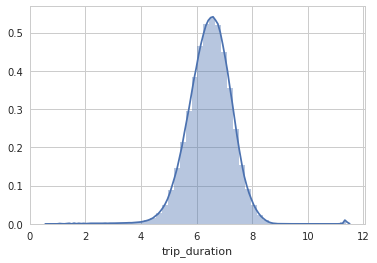

In [5]:
sns.distplot(np.log1p(taxi['trip_duration']), rug=False, kde=True)

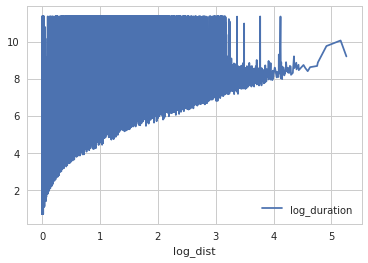

In [6]:
a = taxi.pivot_table("log_duration", "log_dist", aggfunc='mean')
a.plot()

In [7]:
len(taxi[taxi['velo']<1])

13237

In [8]:
taxi['velo'].describe() # 평균 14, 3분위수 17 , 최댓값 79 ...

count    1.458406e+06
mean     1.435743e+01
std      7.748972e+00
min      0.000000e+00
25%      9.114880e+00
50%      1.278294e+01
75%      1.783007e+01
max      7.999080e+01
Name: velo, dtype: float64

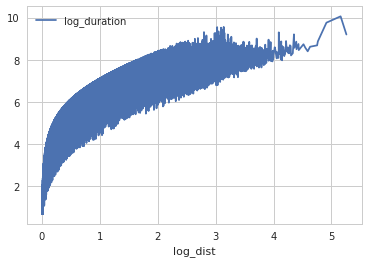

In [9]:
a = taxi[taxi['velo']>5].pivot_table("log_duration", "log_dist", aggfunc='mean')
a.plot()

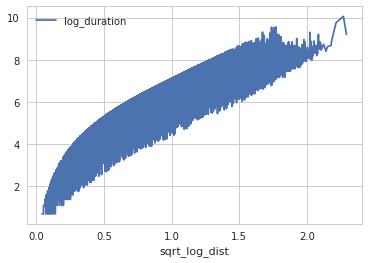

In [4]:
a = taxi[taxi['velo']>5].pivot_table("log_duration", "sqrt_log_dist", aggfunc='mean')
a.plot()

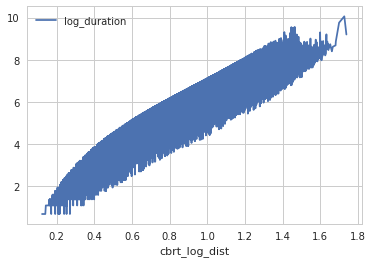

In [5]:
a = taxi[taxi['velo']>5].pivot_table("log_duration", "cbrt_log_dist", aggfunc='mean')
a.plot()

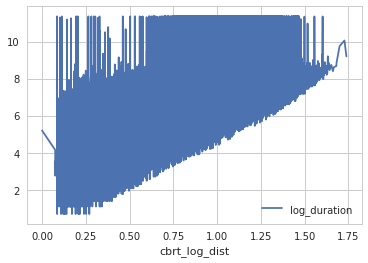

In [6]:
a = taxi.pivot_table("log_duration", "cbrt_log_dist", aggfunc='mean')
a.plot()

이걸로 모델링.

물론 변수에 velo는 못넣음. 아웃라이어 제거용으로 써야할 듯

**log_dist에 제곱근 **

In [11]:
len(taxi[taxi['velo']<10]) # 45만개 제거는 좀..

452604

In [12]:
len(taxi[taxi['velo']<5]) # 7만개 제거정도?

71434

---

### vendor_id

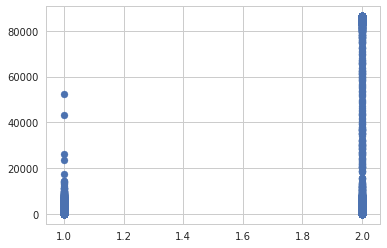

In [13]:
plt.scatter(taxi['vendor_id'], taxi['trip_duration'])

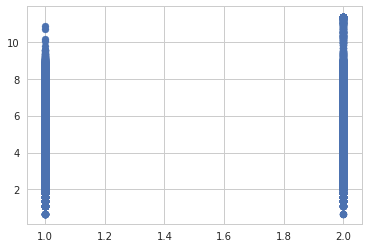

In [14]:
plt.scatter(taxi['vendor_id'], taxi['log_duration'])

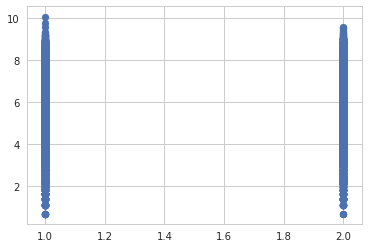

In [15]:
plt.scatter(taxi[taxi['velo']>5]['vendor_id'], taxi[taxi['velo']>5]['log_duration'])

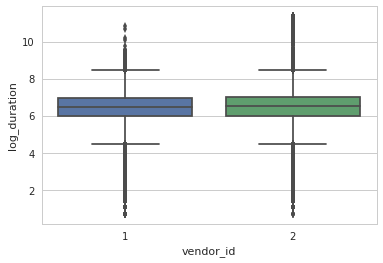

In [16]:
sns.boxplot(x = 'vendor_id', y = 'log_duration', data = taxi)

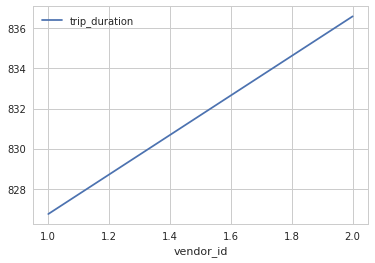

In [35]:
a = taxi[taxi['velo']>5].pivot_table("trip_duration", "vendor_id", aggfunc='mean')
a.plot()

-  vendor 1을 이용한 고객의 trip_duration 분산이 작다
- 근데 **로그씌우면 비슷비슷**
- mean 으로 봐도 10초 안팎의 차이 - 큰 것인가?

## store_and_fwd_flag

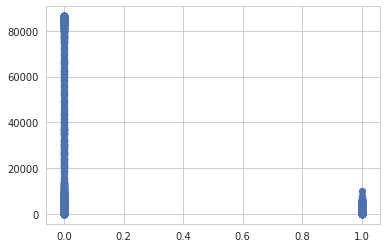

In [17]:
plt.scatter(taxi['store_and_fwd_flag'], taxi['trip_duration'])

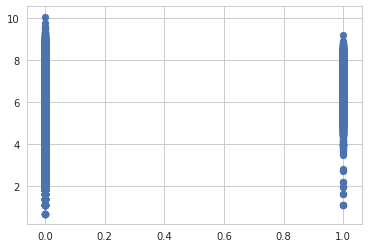

In [18]:
plt.scatter(taxi[taxi['velo']>5]['store_and_fwd_flag'], taxi[taxi['velo']>5]['log_duration'])

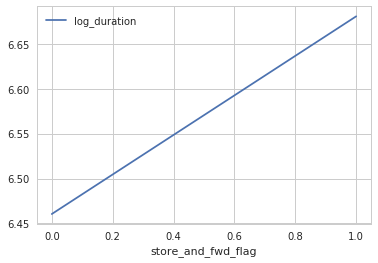

In [22]:
a = taxi[taxi['velo']>5].pivot_table("log_duration", "store_and_fwd_flag", aggfunc='mean')
a.plot()

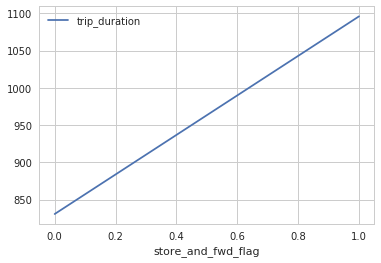

In [27]:
a = taxi[taxi['velo']>5].pivot_table("trip_duration", "store_and_fwd_flag", aggfunc='mean')
a.plot()

로그 씌우니 비슷비슷한 느낌 -인데, 

평균으로 보니 **저장을 한 애들(1)의 듀레이션이 길다** - 카테고리로 사용할만 할듯

In [29]:
abs(np.exp(6.45) - np.exp(6.7)) # 대략 3~4분?

179.70353235528978

In [28]:
1100 - 840

260

## passenger count

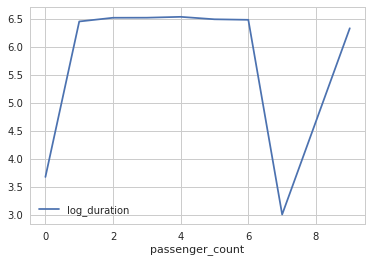

In [19]:
a = taxi.pivot_table("log_duration", "passenger_count", aggfunc='mean')
a.plot()

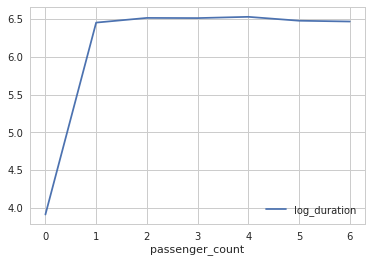

In [49]:
a = taxi[taxi['velo']>1].pivot_table("log_duration", "passenger_count", aggfunc='mean')
a.plot()

속도로 제거하고나면 0 과 그 이외로 나뉨
- 승객 수 0 인애들 아웃라이어로 제거?
- 승객 수 0 인애들 듀레이션 선제적으로 정해줄 수 있을까 - 힘들 듯 
- 승객수 0 인것만 카테고리화 + 인터렉션?( 인터렉션을 한다면 distance 변수와 해야하나?)

In [56]:
a = taxi[taxi['passenger_count'] ==0]
len(a) # 수는 적다. 하지만 적다고 해서..

59

In [55]:
(a[a['velo']<5]).tail()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist,year,...,day,hour,pick_date,pick_time,holiday,weekday,trip_duration,velo,log_duration,log_dist
1296235,948644,2,0,-73.987595,40.719997,-73.987595,40.720005,0,0.000848,2016,...,22,0,52,2424,0,1,1,3.052142,0.693147,0.000847
1368623,3368191,1,0,-73.934937,40.740841,-73.934929,40.740837,0,0.000770,2016,...,8,23,128,85088,0,7,12,0.230889,2.564949,0.000769
1371113,3378693,1,0,-73.783173,40.643848,-73.783173,40.643848,0,0.000000,2016,...,15,15,135,55866,0,7,6,0.000000,1.945910,0.000000
1414107,2684721,2,0,-73.981316,40.746635,-73.981651,40.746811,0,0.034336,2016,...,1,14,91,52929,0,5,48,2.575197,3.891820,0.033760
1444932,1175754,2,0,-73.904610,40.753483,-73.904602,40.753456,0,0.003036,2016,...,14,0,134,1532,0,6,4,2.732461,1.609438,0.003031


# 시간 데이터
- 월 month
- 일 day, pick_date
- 시간 pick_time, hour

## month

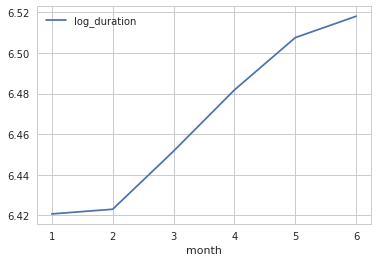

In [13]:
a = taxi.pivot_table("log_duration", "month", aggfunc='mean')
a.plot()

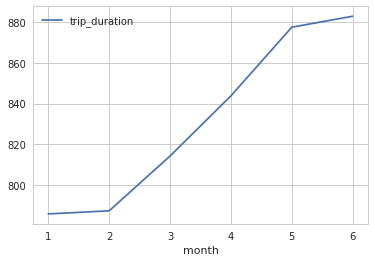

In [32]:
a = taxi[taxi['velo']>5].pivot_table("trip_duration", "month", aggfunc='mean')
a.plot() # 1월에 비해 6월에 평균 80초 이상 듀레이션이 길다

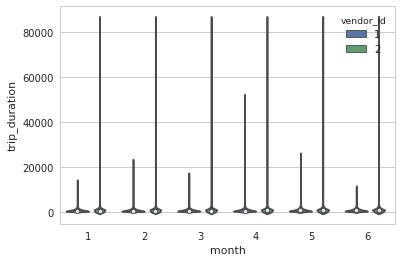

In [33]:
sns.violinplot(x = 'month', y = 'trip_duration', data = taxi, hue='vendor_id')

1월에 비해 6월에 듀레이션이 긴 이유는 무엇일까?
- 날이 더워져서?
- 외출 증가 -> 차가 많아 져서 -> 교통 체증?


3차, 혹은 1차 정도로 표현할 수 있을 것 같다. violinplot 과 다른 이유는 뭘까
- 아마도 아웃라이어 때문?
- 이렇게 봐도 밴더 2 이용 고객의 듀레이션이 길다

## day 0-31

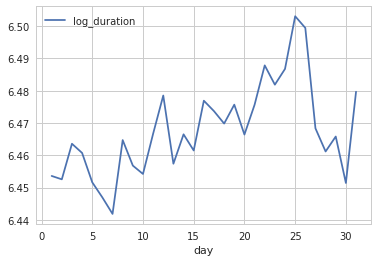

In [15]:
a = taxi.pivot_table("log_duration", "day", aggfunc='mean')
a.plot()

뭘로 표현해야 되지? sin? 3차, 4차 정도로 간략하게?

pick date 0 - 180
- 이건...? day가 나을듯

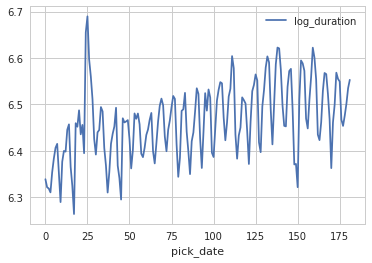

In [18]:
a = taxi.pivot_table("log_duration", "pick_date", aggfunc='mean')
a.plot()

## hour

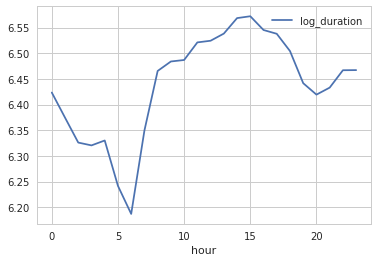

In [20]:
a = taxi.pivot_table("log_duration", "hour", aggfunc='mean')
a.plot()

차수를 높이면 표현 할 수도 있지 않을까 4차?

#### pick_time

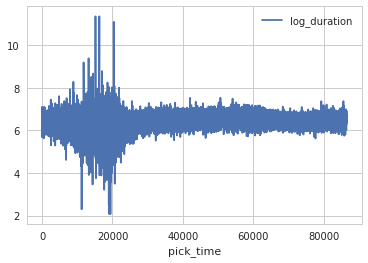

In [62]:
a = taxi.pivot_table("log_duration", "pick_time", aggfunc='mean')
a.plot()

너무 촘촘해서 hour가 나을 듯 싶다.

### weekday

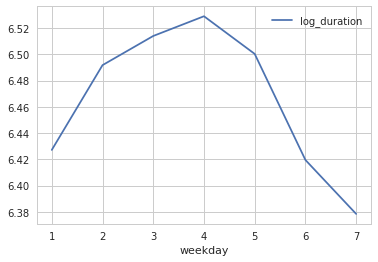

In [70]:
a = taxi.pivot_table("log_duration", "weekday", aggfunc='mean')
a.plot()

2차? 카테고리인데 어떻게 해야하지.. interaction?

---